In [3]:
import pandas as pd
from cartopy import crs as ccrs
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
# import gfdl_utils as gu
import glob
import re
from scipy.interpolate import griddata
import geopy
import cmocean.cm as cmo
import cmocean
import gsw
from geopy import distance
import xesmf as xe
# import sectionate
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook")
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150


In [4]:
def GLODAPP_LON_to_CM4X(lons):
    lons_copy = 1 * lons 
    lons_copy[lons_copy > 60] -= 360
    return lons_copy
def CM4X_LON_to_GLODAPP(lons): 
    lons_copy = 1 * lons 
    lons_copy[(lons_copy > -300) * (lons_copy < -180)] +=360
    return lons_copy

def CM4X_to_reg_grid(ds): 
    xhcopy = 1 * ds.xh.values
    xhcopy[(ds.xh > -300) * (ds.xh < -180)] += 360
    
    ds_copy = 1 * ds
    ds_copy.coords['xh'] = 1 * xhcopy

    return ds_copy.reindex({ "xh" : xhcopy})

def read_CM4X(fname): 
    return xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"latitude":-1, "longitude":-1},
        engine="zarr")

def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")

In [5]:
# from dask_jobqueue import SLURMCluster  # setup dask cluster 
# cluster = SLURMCluster(
#     cores=36,
#     processes=1,
#     memory='125GB',
#     walltime='02:00:00',
#     queue='compute',
#     interface='ib0', 
#     log_directory = slurmscratchdir)
# print(cluster.job_script())
# cluster.scale(jobs=5)
# from dask.distributed import Client
# client = Client(cluster)
# client

In [6]:
# GLODAP:model variable naming conventions
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmol kg-1'},
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmol kg-1'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'Blues','units':'fmol kg-1'},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'thetao':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'deg C','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(32,37,0.05),'anombins':np.arange(-1,1.02,0.02)}
}

In [8]:
def read_CM4X(fname): 
    ds = xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        engine="zarr")
    
    ds = ds.drop(["lat", "lon"])
    ds = ds.rename({"geolat":"lat", "geolon":"lon"})
    # ds = approximate_z(ds)
    ds = ds.where(ds.thkcello > 1e-9)
    return ds

def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")
ds = read_CM4X(datadir("model/yearly_output_0.25deg/CM4Xp125_historical_transient_tracers.zarr"))
ds_ctrl = read_CM4X(datadir("model/yearly_output_0.25deg/CM4Xp125_piControl_transient_tracers.zarr"))
ds_ctrl = ds_ctrl.isel(year = slice(None, 165))

/tmp/ipykernel_215336/672036769.py:10: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.drop(["lat", "lon"])
/tmp/ipykernel_215336/672036769.py:10: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.drop(["lat", "lon"])


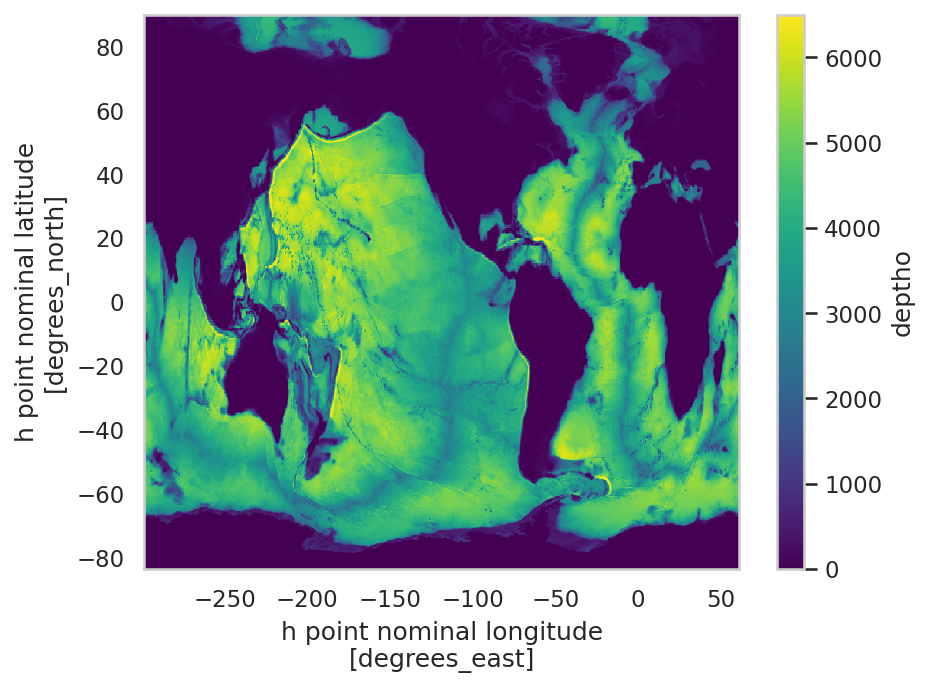

In [12]:
ds.deptho.compute().plot()

In [ ]:
def weighted_average(ds):
    weights = ds.thkcello * ds.areacello
    weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh", "yh"]) / weights.sum(["xh", "yh"])
    return weighted_ds

### Define Southern Ocean Mask

In [ ]:
from matplotlib import colors as c

SO_mask = ds_ctrl.thetao.isel(year = 0, zl = 0)
SO_mask = SO_mask.where(ds_ctrl.lat < -40)
SO_mask = xr.where(~np.isnan(SO_mask), 1, np.nan)

# Define the figure and each axis for the 3 rows and 3 columns
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 180)},
                        figsize=(7,5))
ax.set_title("Southern Ocean Mask")
ax.pcolormesh(SO_mask.lon, SO_mask.lat, SO_mask, 
              transform=ccrs.PlateCarree(), cmap=c.ListedColormap(['r']), alpha = 0.5)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.0)
gl.top_labels = False
gl.right_labels = False

### Compute sigma2 on Southern Ocean

In [ ]:
ds_ctrl = get_sigma2(ds_ctrl)
ds = get_sigma2(ds)

In [ ]:
ctrl_global = weighted_average(ds_ctrl.where(ds_ctrl.lat < -40)).compute()
hist_global = weighted_average(ds.where(ds.lat < -40)).compute()

In [ ]:
ctrl_global.to_netcdf(datadir("CM4Xp125_piControl_SO_40S.nc"))
hist_global.to_netcdf(datadir("CM4Xp125_historical_SO_40S.nc"))

In [5]:
ctrl_global = xr.open_dataset(datadir("CM4Xp125_piControl_SO_40S.nc"))
hist_global = xr.open_dataset(datadir("CM4Xp125_historical_SO_40S.nc"))

### Plot CFCs in Southern Ocean as a function of Depth and Time

In [6]:
#interpolation
interp_ctrl_timeseries = interpolate_section(ctrl_global, -np.arange(100, 7000), interp_coord = "z", iterate_coord = "year")
interp_hist_timeseries = interpolate_section(hist_global, -np.arange(100, 7000), interp_coord = "z", iterate_coord = "year")
interp_ctrl_timeseries.coords['year'] = interp_hist_timeseries.coords['year']

In [27]:
#define sigma levels
siglevels = np.arange(36.2, 37.4, .2) 
siglevels = 1.0 * np.sort(np.append(siglevels, [37.11, 37.21, 37.22, 37.23, 37.24]))
siglevels

array([36.2 , 36.4 , 36.6 , 36.8 , 37.  , 37.11, 37.2 , 37.21, 37.22,
       37.23, 37.24])

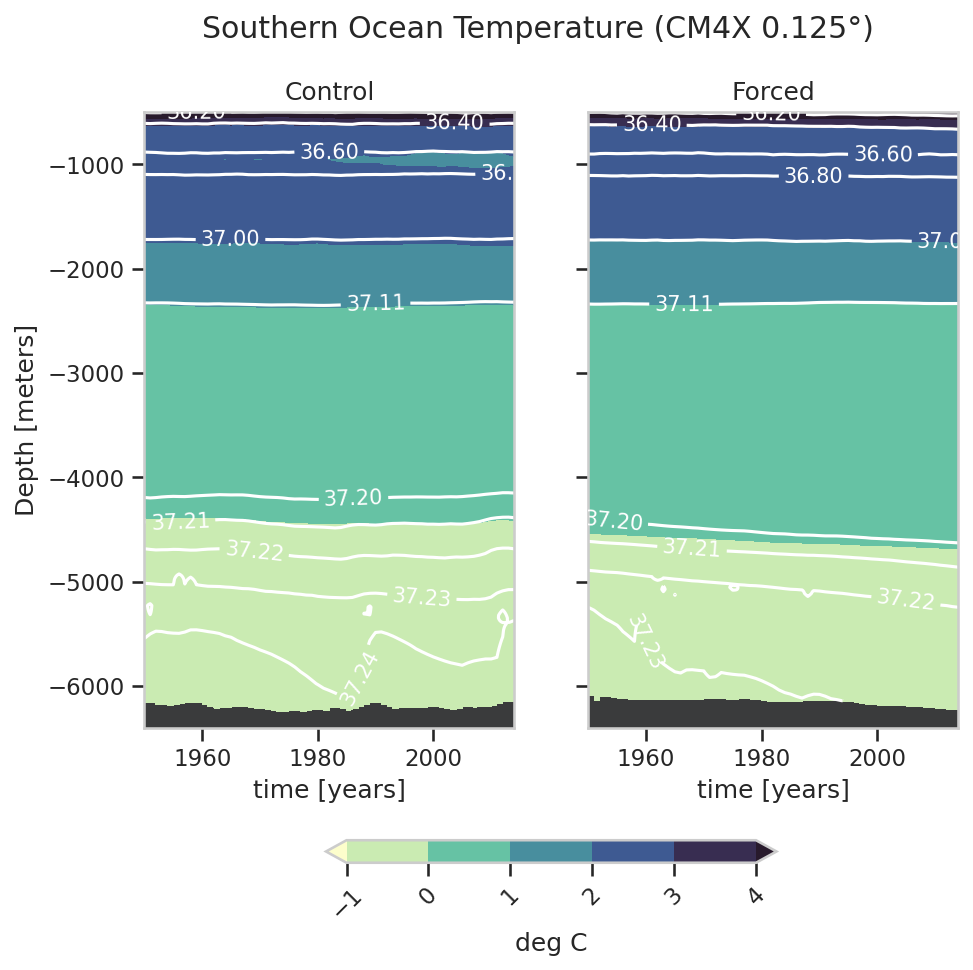

In [28]:
fig, ax = plt.subplots(1, 2, figsize = (7, 6.5), sharey = False)
levels = np.arange(-1, 5)
tracer = "thetao"; tracername = "Temperature"
fig.suptitle(f"Southern Ocean {tracername} (CM4X 0.125°)")

tmp1 = interp_ctrl_timeseries[[tracer, "sigma2"]]
tmp1 = tmp1.sel(year = slice(1950, 2014)) 
ax[0].contourf(tmp1.year, tmp1.z, tmp1[tracer], cmap = cmo.deep, extend = "both", levels = levels)
cnt = ax[0].contour(tmp1.year, tmp1.z, tmp1.sigma2, levels = siglevels, colors = "white");
cs = ax[0].clabel(cnt, inline=True, fontsize=10)
ax[0].set_ylabel("Depth [meters]")
ax[0].set_xlabel("time [years]")
ax[0].set_title("Control")

tmp2 = interp_hist_timeseries[[tracer, "sigma2"]]
tmp2 = tmp2.sel(year = slice(1950, 2014)) 
cm = ax[1].contourf(tmp2.year, tmp2.z, tmp2[tracer], cmap = cmo.deep, extend = "both", levels = levels)
cnt2 = ax[1].contour(tmp2.year, tmp2.z, tmp2.sigma2, colors = "white", levels = siglevels)
cs = ax[1].clabel(cnt2, inline=True, fontsize=10)
ax[1].set_yticklabels([])
ax[1].set_title("Forced")
ax[1].set_xlabel("time [years]")

[a.set_facecolor("#3A3B3C") for a in ax]
[a.grid(alpha = 0) for a in ax]
[a.set_ylim(-6400, -500) for a in ax]
[a.tick_params(bottom=True, left=True) for a in ax.flatten()];

cbar = fig.colorbar(cm, ax = ax[0:2], label = variable_kwargs[tracer]["units"], 
                    orientation = "horizontal", fraction = 0.03)
cbar.ax.tick_params(rotation=45)

fig.savefig(plotsdir("paper_figures/SouthernOceanTemperature.png"), bbox_inches = "tight", dpi = 100)

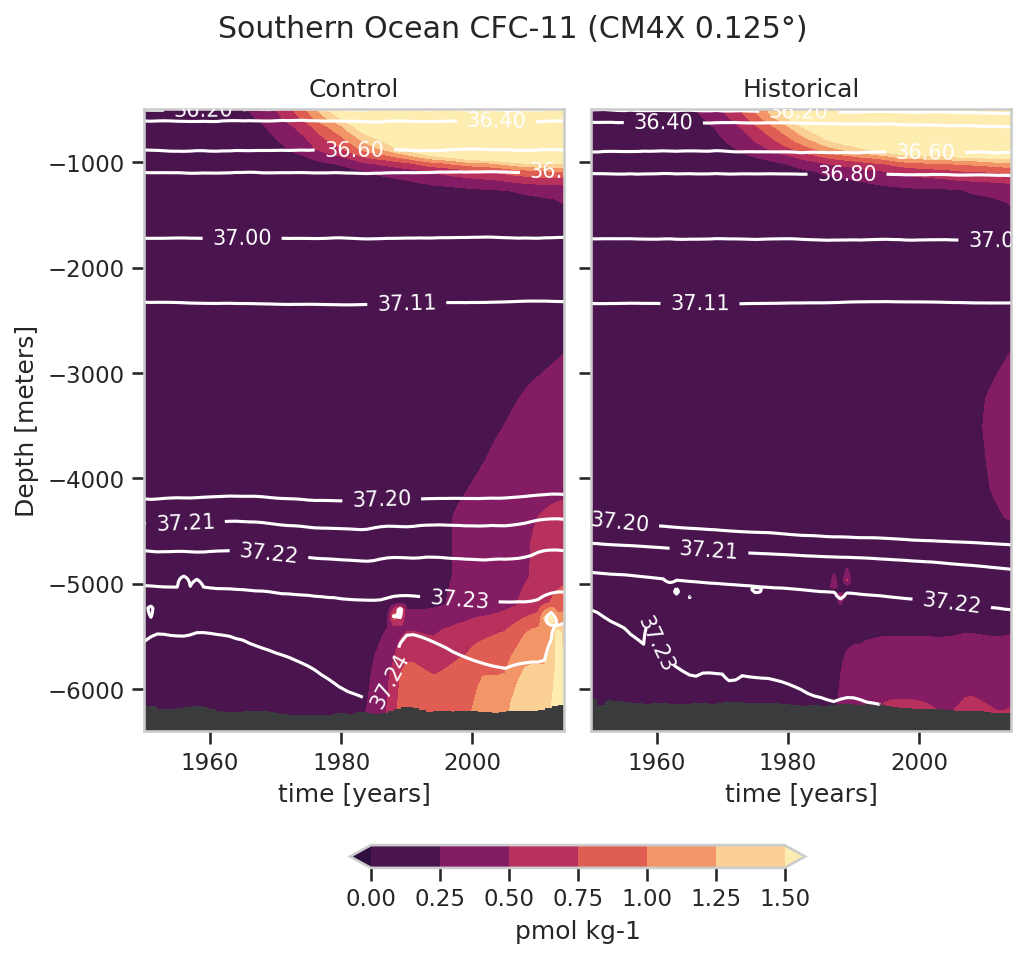

In [29]:
levels = np.arange(0, 1.51, 0.25)

fig, ax = plt.subplots(1, 2, figsize = (7, 6.5), sharey = False)
tracer = "cfc11"; tracername = "CFC-11"
fig.suptitle(f"Southern Ocean {tracername} (CM4X 0.125°)")

tmp1 = interp_ctrl_timeseries[[tracer, "sigma2"]]
tmp1 = tmp1.sel(year = slice(1950, 2014)) 
tmp1[tracer] = tmp1[tracer] * variable_kwargs[tracer]["conversion"]
tmp1[tracer] = tmp1[tracer].where(tmp1[tracer] >= 0)
ax[0].contourf(tmp1.year, tmp1.z, tmp1[tracer], levels = levels, 
               cmap = cmo.matter_r, extend = "both")
cnt = ax[0].contour(tmp1.year, tmp1.z, tmp1.sigma2, levels = siglevels, colors = "white");
cs = ax[0].clabel(cnt, inline=True, fontsize=10)
ax[0].set_ylabel("Depth [meters]")
ax[0].set_title("Control")
ax[0].set_xlabel("time [years]")

tmp2 = interp_hist_timeseries[[tracer, "sigma2"]]
tmp2 = tmp2.sel(year = slice(1950, 2014)) 
tmp2[tracer] = tmp2[tracer] * variable_kwargs[tracer]["conversion"]
tmp2[tracer] = tmp2[tracer].where(tmp2[tracer] > 0)
cm = ax[1].contourf(tmp2.year, tmp2.z, tmp2[tracer], levels = levels, 
               cmap = cmo.matter_r, extend = "both")
cnt2 = ax[1].contour(tmp2.year, tmp2.z, tmp2.sigma2, colors = "white", levels = siglevels)
cs = ax[1].clabel(cnt2, inline=True, fontsize=10)
ax[1].set_yticklabels([])
ax[1].set_title("Historical")
ax[1].set_xlabel("time [years]")

fig.tight_layout()

[a.set_facecolor("#3A3B3C") for a in ax]
[a.grid(alpha = 0) for a in ax]
[a.set_ylim(-6400, -500) for a in ax]
[a.tick_params(bottom=True, left=True) for a in ax.flatten()];

fig.colorbar(cm, ax = ax[0:2], label = variable_kwargs[tracer]["units"], 
             orientation = "horizontal", fraction = 0.03)

fig.savefig(plotsdir("paper_figures/SouthernOceanCFC11.png"), bbox_inches = "tight", dpi = 100)

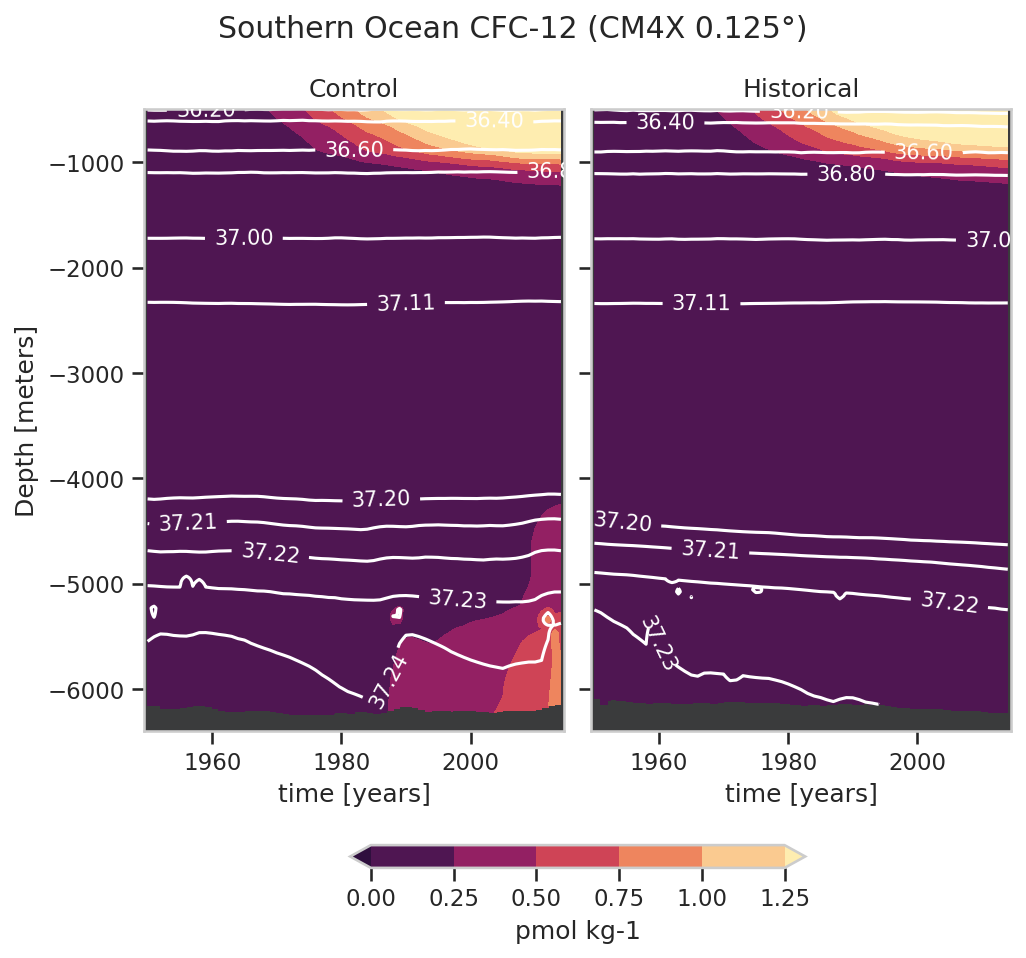

In [30]:
levels = np.arange(0, 1.251, 0.25)

fig, ax = plt.subplots(1, 2, figsize = (7, 6.5), sharey = False)
tracer = "cfc12"; tracername = "CFC-12"
fig.suptitle(f"Southern Ocean {tracername} (CM4X 0.125°)")

tmp1 = interp_ctrl_timeseries[[tracer, "sigma2"]]
tmp1 = tmp1.sel(year = slice(1950, 2014)) 
tmp1[tracer] = tmp1[tracer] * variable_kwargs[tracer]["conversion"]
tmp1[tracer] = tmp1[tracer].where(tmp1[tracer] >= 0)
ax[0].contourf(tmp1.year, tmp1.z, tmp1[tracer], levels = levels, 
               cmap = cmo.matter_r, extend = "both")
cnt = ax[0].contour(tmp1.year, tmp1.z, tmp1.sigma2, levels = siglevels, colors = "white");
cs = ax[0].clabel(cnt, inline=True, fontsize=10)
ax[0].set_ylabel("Depth [meters]")
ax[0].set_title("Control")
ax[0].set_xlabel("time [years]")

tmp2 = interp_hist_timeseries[[tracer, "sigma2"]]
tmp2 = tmp2.sel(year = slice(1950, 2014)) 
tmp2[tracer] = tmp2[tracer] * variable_kwargs[tracer]["conversion"]
tmp2[tracer] = tmp2[tracer].where(tmp2[tracer] > 0)
cm = ax[1].contourf(tmp2.year, tmp2.z, tmp2[tracer], levels = levels, 
               cmap = cmo.matter_r, extend = "both")
cnt2 = ax[1].contour(tmp2.year, tmp2.z, tmp2.sigma2, colors = "white", levels = siglevels)
cs = ax[1].clabel(cnt2, inline=True, fontsize=10)
ax[1].set_yticklabels([])
ax[1].set_title("Historical")
ax[1].set_xlabel("time [years]")

fig.tight_layout()

[a.set_facecolor("#3A3B3C") for a in ax]
[a.grid(alpha = 0) for a in ax]
[a.set_ylim(-6400, -500) for a in ax]
[a.set_xlim(1949.5, 2014.5) for a in ax]

[a.tick_params(bottom=True, left=True) for a in ax.flatten()];

fig.colorbar(cm, ax = ax[0:2], label = variable_kwargs[tracer]["units"], 
             orientation = "horizontal", fraction = 0.03)
fig.savefig(plotsdir("SouthernOceanCFC12.png"), bbox_inches = "tight", dpi = 100)

In [ ]:
ds = read_CM4X(datadir("model/yearly_output_0.25deg/CM4Xp125_historical_transient_tracers.zarr"))
ds_ctrl = read_CM4X(datadir("model/yearly_output_0.25deg/CM4Xp125_piControl_transient_tracers.zarr"))
ds_ctrl = ds_ctrl.isel(year = slice(None, 165))

In [ ]:
ds_ctrl = get_sigma2(ds_ctrl)
ds = get_sigma2(ds)

In [ ]:
water_mass_mask = lambda ds: ds.where((ds.lat < -40) * (ds.sigma2 >=37.))

def volume_average(ds):
    weights = ds.thkcello * ds.areacello
    weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh", "yh", "zl"]) / weights.sum(["xh", "yh", "zl"])
    return weighted_ds
    

In [ ]:
weighted_average(ds_ctrl.where(ds_ctrl.lat < -40))